In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!apt-get update
!apt-get install -y libglu1-mesa


Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:9 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,608 kB]
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:11 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:12 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [2,424 kB]
Get:13 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packa

In [ ]:
!pip install micromlgen

  Preparing metadata (setup.py) ... done
  Created wheel for micromlgen: filename=micromlgen-1.1.28-py3-none-any.whl size=32153 sha256=dc0ae3641ad3c9938209079ed79b9452f53f5c4730789e0df257fd1b93ea52cd
  Stored in directory: /root/.cache/pip/wheels/97/54/64/5d82c310920abe1be0d120313ceb9e12c88f5701f53f6ed248
Successfully built micromlgen


In [ ]:
import pandas as pd

# Load dataset
data = pd.read_csv('/content/drive/MyDrive/SKRIPSII/CODE PROGRAM/COBA/EMG-data.csv/emg-data-10-subjects.csv')
data.head()

,Channel1,Channel2,Channel3,Channel4,Channel5,Channel6,Channel7,Channel8,Class,Label
0,254,200,253,114,244,118,254,156,0,1
1,183,202,250,114,253,82,232,202,0,1
2,255,114,103,206,255,118,237,86,0,1
3,227,114,227,238,54,82,251,202,0,1
4,251,118,227,247,190,47,255,82,0,1


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.svm import SVC
from joblib import dump
from scipy.ndimage import gaussian_filter
from imblearn.over_sampling import SMOTE
from micromlgen import port

# Fungsi untuk menerapkan Gaussian Filter
def apply_gaussian_filter(data, sigma=1.6, kernel=11):
    return gaussian_filter(data, sigma=sigma)

# Fungsi untuk menghitung WL (Waveform Length)
def calculate_wl(data):
    # Hitung WL per kanal secara independen
    return np.sum(np.abs(np.diff(data, axis=0)), axis=0)

# Fungsi untuk menerapkan sliding window dan menghitung WL
def apply_sliding_window_wl(data, window_size=300, stride=1):
    n_samples, n_features = data.shape
    wl_features = []

    for start in range(0, n_samples - window_size + 1, stride):
        window = data[start:start + window_size, :]
        wl = calculate_wl(window)
        wl_features.append(wl)

    return np.array(wl_features)

# Misalkan data telah dimuat dalam DataFrame 'data'
X = data.iloc[:, :-2].values
y = data.iloc[:, -2].values

X_filtered = apply_gaussian_filter(X)
X_wl = apply_sliding_window_wl(X_filtered)

X_min = X_wl.min()
X_max = X_wl.max()
X_normalized = ((X_wl - X_min) / (X_max - X_min)) * 255

"""# Convert to uint8 data type
X_normalized = X_normalized.astype(np.uint8)"""

df_features = pd.DataFrame(X_normalized)
df_features['class'] = y[:len(df_features)]
csv_filename = 'extracted_features.csv'
df_features.to_csv(csv_filename, index=False)

kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold = 1
accuracies = []
smote = SMOTE(random_state=42)

for train_index, test_index in kf.split(X_normalized):
    print(f'Fold {fold}')
    X_train, X_test = X_normalized[train_index], X_normalized[test_index]
    y_train, y_test = y[train_index], y[test_index]
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

    svm_model = SVC(kernel='rbf', C=10, gamma=0.001)  # Langsung menggunakan SVC
    start_time = time.time()
    svm_model.fit(X_train_resampled, y_train_resampled)
    end_time = time.time()

    y_pred = svm_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)
    print(f'Akurasi: {accuracy}')
    print(f'Waktu yang dibutuhkan untuk fold {fold}: {end_time - start_time:.4f} seconds')

    model_filename = f'svm_model_fold{fold}.joblib'
    dump(svm_model, model_filename)

    header_filename = f'svm_model_fold{fold}.h'
    with open(header_filename, 'w') as header_file:
        header_content = port(svm_model, compressed=True)  # Menggunakan fungsi port dari micromlgen
        header_file.write(header_content)

    print(f'Model SVM dalam format .h disimpan untuk fold {fold}.')
    fold += 1

mean_accuracy = np.mean(accuracies)
print(f'Mean Accuracy: {mean_accuracy}')


Fold 1
Akurasi: 0.9297597042513863
Waktu yang dibutuhkan untuk fold 1: 0.1386 seconds
Model SVM dalam format .h disimpan untuk fold 1.
Fold 2
Akurasi: 0.9388888888888889
Waktu yang dibutuhkan untuk fold 2: 0.1831 seconds
Model SVM dalam format .h disimpan untuk fold 2.
Fold 3
Akurasi: 0.9314814814814815
Waktu yang dibutuhkan untuk fold 3: 0.1763 seconds
Model SVM dalam format .h disimpan untuk fold 3.
Fold 4
Akurasi: 0.9481481481481482
Waktu yang dibutuhkan untuk fold 4: 0.1326 seconds
Model SVM dalam format .h disimpan untuk fold 4.
Fold 5
Akurasi: 0.95
Waktu yang dibutuhkan untuk fold 5: 0.3177 seconds
Model SVM dalam format .h disimpan untuk fold 5.
Mean Accuracy: 0.939655644553981


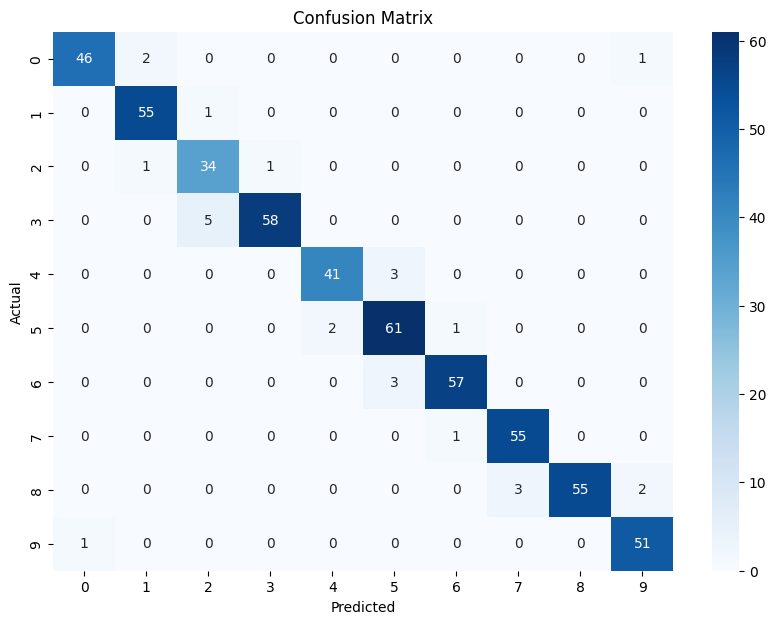

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.94      0.96        49
           1       0.95      0.98      0.96        56
           2       0.85      0.94      0.89        36
           3       0.98      0.92      0.95        63
           4       0.95      0.93      0.94        44
           5       0.91      0.95      0.93        64
           6       0.97      0.95      0.96        60
           7       0.95      0.98      0.96        56
           8       1.00      0.92      0.96        60
           9       0.94      0.98      0.96        52

    accuracy                           0.95       540
   macro avg       0.95      0.95      0.95       540
weighted avg       0.95      0.95      0.95       540



In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Buat confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Visualisasikan confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Cetak classification report
report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)


Konversikan file .npy menjadi array C/C++

In [ ]:
import numpy as np
from joblib import load

# Fungsi untuk menguji model dengan input data dari user
def test_model(model, input_data):
    """Menggunakan model yang telah dilatih untuk memprediksi kelas berdasarkan input data."""
    # Ubah input data menjadi array
    input_array = np.array(input_data).reshape(1, -1)

    # Prediksi kelas menggunakan model
    predicted_class = model.predict(input_array)

    return predicted_class

# Load model yang telah disimpan (misalnya dari fold terakhir)
model = load('svm_model_fold4.joblib')

# Tampilkan pesan contoh input dan minta user memasukkan data
print("Masukkan 8 channel input data:")
user_input = list(map(float, input().split()))

# Uji model dengan input dari user
predicted_class = test_model(model, user_input)

# Tampilkan hasil prediksi kelas
print(f"Hasil prediksi kelas: {predicted_class[0]}")


Masukkan 8 channel input data:
151.6383495145631	92.63349514563106	44.9757281553398	29.08980582524272	15.885922330097088	28.47087378640777	92.63349514563106	161.74757281553397
Hasil prediksi kelas: 0
